<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/pedro/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *

In [3]:
dataset_path = '/content/gdrive/MyDrive/Capstone/Data/munich_data'

# define mask function

def mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = dataset_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)


In [37]:
# Create datablock
parks_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=mask_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

# Dataloaders with batch size 4

dls16 = parks_block.dataloaders(dataset_path, bs=4)

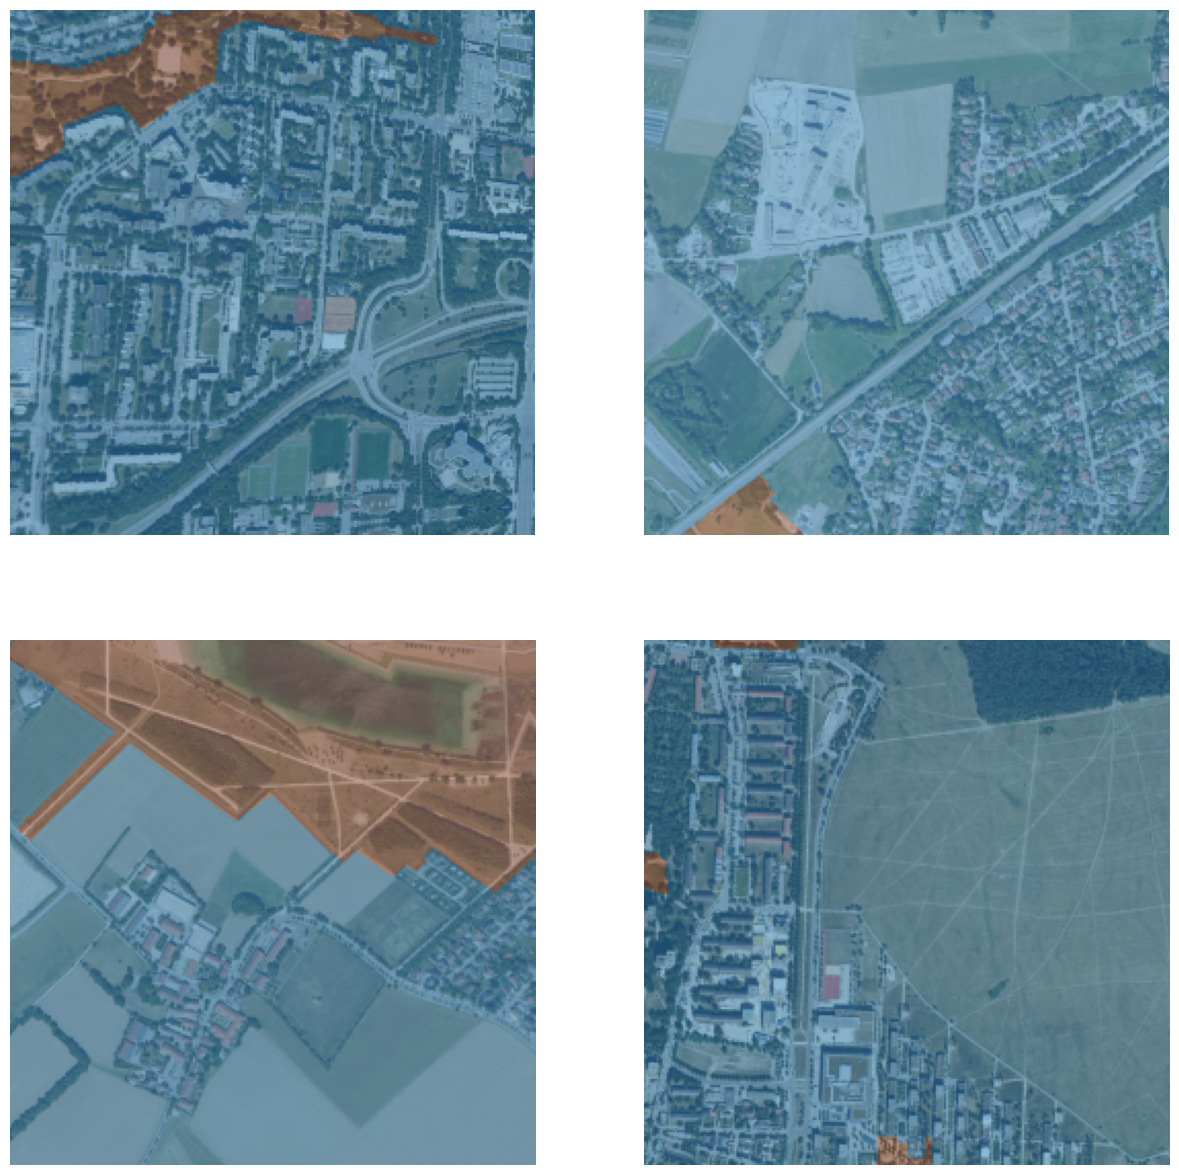

In [35]:
dls16.show_batch(figsize=(15, 15))

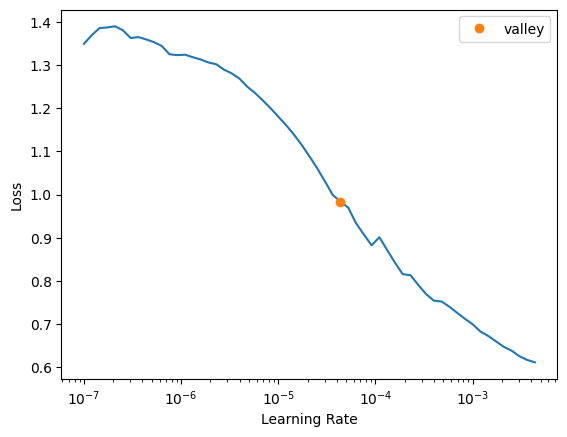

In [7]:
# Create a U-Net model
learn_RELU = unet_learner(dls16,resnet34,metrics=Dice)
lr_RELU = learn.lr_find()

In [10]:
# Train the U-Net model.
learn_RELU.fit_one_cycle(40, lr_max=lr_RELU.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_RELU')])

epoch,train_loss,valid_loss,dice,time
0,0.282177,0.252192,0.000084,00:24
1,0.262228,0.237974,0.000050,00:24
2,0.256704,0.227050,0.000039,00:28
3,0.241093,0.218438,0.000011,00:25
4,0.267397,0.236242,0.000011,00:24
5,0.258246,0.203959,0.000156,00:24
6,0.230075,0.192691,0.003381,00:25
7,0.208949,0.189866,0.045989,00:23
8,0.210541,0.181012,0.251495,00:25
9,0.228444,0.214596,0.209097,00:24


Better model found at epoch 0 with dice value: 8.354986673796255e-05.
Better model found at epoch 7 with dice value: 0.04598867511917714.
Better model found at epoch 8 with dice value: 0.2514946482315404.
Better model found at epoch 11 with dice value: 0.3135922056345177.
Better model found at epoch 13 with dice value: 0.41489691482148866.
Better model found at epoch 21 with dice value: 0.4257068274568918.
No improvement since epoch 21: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


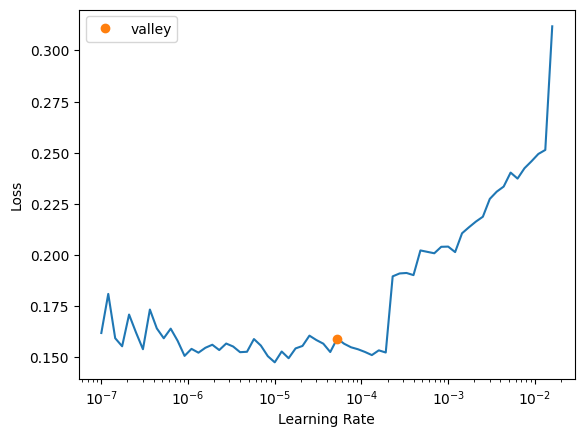

In [11]:
# Unfreeze the last layers of the model
learn_RELU = learn_RELU.load('best_frozen_RELU')
learn_RELU.unfreeze()
lr_RELU = learn_RELU.lr_find()

In [14]:
# Train the last layers
learn_RELU.fit_one_cycle(
    40, lr_max=slice(lr_RELU.valley/10,lr_RELU.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_model_RELU')]
         )



epoch,train_loss,valid_loss,dice,time
0,0.163235,0.176928,0.390961,00:25
1,0.191062,0.178957,0.198860,00:25
2,0.197791,0.187542,0.050642,00:26
3,0.192551,0.208785,0.000000,00:24
4,0.205346,0.180759,0.027890,00:26
5,0.215054,0.186306,0.001236,00:28
6,0.239828,0.208808,0.000000,00:24
7,0.219790,0.182402,0.000000,00:25
8,0.210142,0.202030,0.000000,00:26
9,0.192072,0.196555,0.429614,00:25


Better model found at epoch 0 with dice value: 0.3909608408253395.
Better model found at epoch 9 with dice value: 0.42961383503490047.
Better model found at epoch 12 with dice value: 0.43178723719067713.
Better model found at epoch 14 with dice value: 0.5106134386926426.
Better model found at epoch 24 with dice value: 0.5142796421057105.
No improvement since epoch 14: early stopping


In [15]:
learn_RELU = learn_RELU.load("best_model_RELU")
print("in-sample performance: {}".format(np.array(learn_RELU.validate(ds_idx=0)[1])))

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


in-sample performance: 0.7919320637059856


In [16]:
print("out-of-sample performance: {}".format(np.array(learn_RELU.validate(ds_idx=1)[1])))

out-of-sample performance: 0.5142796421057105


In the next sections we will experiment with different activation functions (ELU, LeakyReLU, PReLU) with the U-Net architecture and resnet34 model, while keeping all transformations and batch size constant.


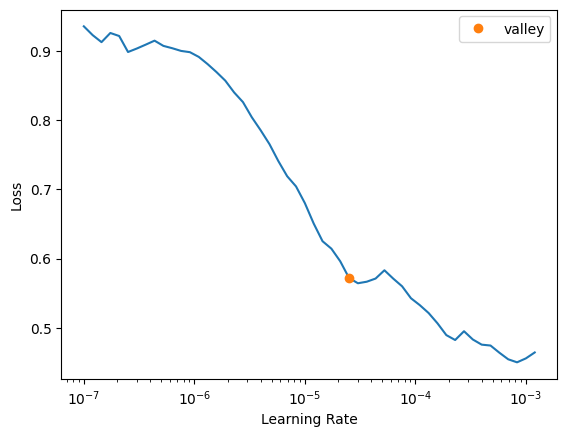

In [19]:
# Exponential Linear Unit (ELU) activation function:

learn_ELU = unet_learner(dls16, resnet34, metrics=Dice, act_cls=torch.nn.modules.activation.ELU)
lr_ELU = learn_ELU.lr_find()

In [20]:
# Train the first layers of the ELU activated model:

learn_ELU.fit_one_cycle(40, lr_max=lr_ELU.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_fr')])

epoch,train_loss,valid_loss,dice,time
0,0.424195,0.336625,0.025081,00:26
1,0.332149,0.288787,0.023361,00:25
2,0.301215,0.253657,0.024226,00:24
3,0.272286,0.230351,0.039619,00:26
4,0.246165,0.222990,0.086917,00:25
5,0.223165,0.216576,0.206022,00:24
6,0.223117,0.202790,0.342475,00:25
7,0.212372,0.201141,0.177800,00:24
8,0.226289,0.194272,0.333827,00:25
9,0.206744,0.213418,0.237633,00:25


Better model found at epoch 0 with dice value: 0.025080649839146516.
Better model found at epoch 3 with dice value: 0.03961862594113621.
Better model found at epoch 4 with dice value: 0.08691702465086917.
Better model found at epoch 5 with dice value: 0.2060218927274922.
Better model found at epoch 6 with dice value: 0.34247531992687386.
Better model found at epoch 11 with dice value: 0.41189335680933514.
Better model found at epoch 18 with dice value: 0.43705321098340977.
Better model found at epoch 20 with dice value: 0.47186137296281594.
Better model found at epoch 22 with dice value: 0.4858618295091731.
No improvement since epoch 22: early stopping


The ELU activation function drastically accelerated the learning process of the model. A dice score of over 0.5 was reached as soon as epoch 19 of training, as opposed to the previous model, which used the Rectified Linear Unit activation function, and reached a comparable dice score only after unfreezing its last layers.

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


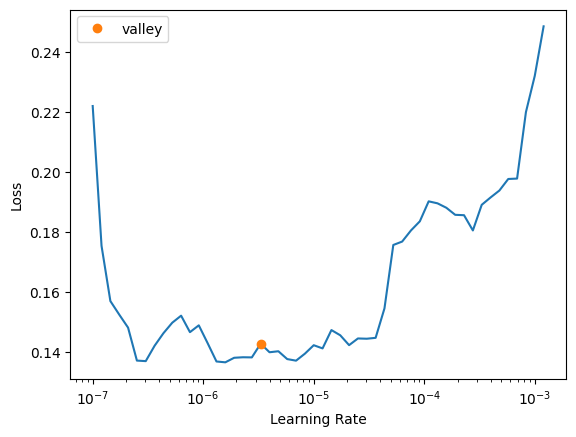

In [21]:
learn_ELU = learn_ELU.load('best_fr')
learn_ELU.unfreeze()
lr_ELU = learn_ELU.lr_find()

In [22]:
# Train the last layers
learn_ELU.fit_one_cycle(
    40, lr_max=slice(lr_ELU.valley/10,lr_ELU.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_ELU_model')]
         )

epoch,train_loss,valid_loss,dice,time
0,0.138098,0.186509,0.470027,00:27
1,0.132448,0.190019,0.426681,00:28
2,0.133108,0.188375,0.404573,00:25
3,0.136788,0.205608,0.475855,00:26
4,0.138964,0.183463,0.345220,00:26
5,0.139031,0.184267,0.496730,00:26
6,0.131519,0.203417,0.318755,00:25
7,0.137636,0.194673,0.324730,00:26
8,0.131902,0.191344,0.391159,00:27
9,0.133220,0.180798,0.416928,00:25


Better model found at epoch 0 with dice value: 0.4700265687591275.
Better model found at epoch 3 with dice value: 0.4758554472391214.
Better model found at epoch 5 with dice value: 0.4967298026907798.
No improvement since epoch 5: early stopping


In [23]:
learn_ELU = learn_ELU.load("best_ELU_model")
print("in-sample performance: {}".format(np.array(learn_ELU.validate(ds_idx=0)[1])))

in-sample performance: 0.6769990222566779


In [24]:
print("our-of-sample performance: {}".format(np.array(learn_ELU.validate(ds_idx=1)[1])))

our-of-sample performance: 0.4967298026907798


The ELU activation function provided slightly better performance than RELU.
Next, we will try the LeakyRELU activation function.

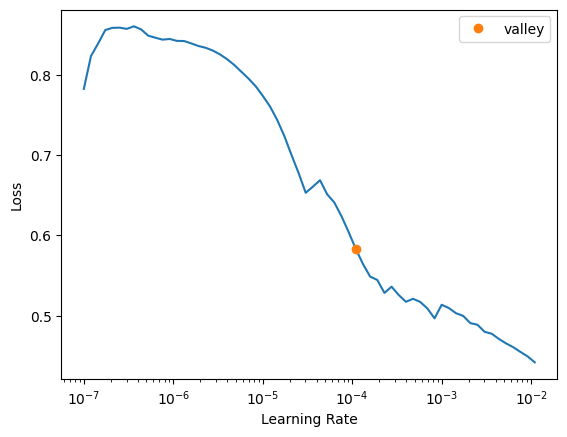

In [25]:
learn_leaky = unet_learner(dls16, resnet34, metrics=Dice, act_cls=torch.nn.modules.activation.LeakyReLU)
lr_leaky = learn_leaky.lr_find()

In [26]:
learn_leaky.fit_one_cycle(40, lr_max=lr_leaky.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_leaky')])

epoch,train_loss,valid_loss,dice,time
0,0.325838,0.271098,0.002660,00:25
1,0.291474,0.252811,0.000189,00:25
2,0.270347,0.280778,0.001825,00:26
3,0.267912,0.241323,0.000000,00:25
4,0.254664,0.211793,0.001141,00:27
5,0.250652,0.209476,0.000000,00:25
6,0.236669,0.218611,0.315305,00:25
7,0.237092,0.189406,0.066167,00:25
8,0.226591,0.214531,0.000256,00:25
9,0.202416,0.204394,0.123676,00:24


Better model found at epoch 0 with dice value: 0.0026597644679646755.
Better model found at epoch 6 with dice value: 0.3153048088437248.
Better model found at epoch 10 with dice value: 0.4224311943416279.
Better model found at epoch 11 with dice value: 0.43265009989012954.
Better model found at epoch 12 with dice value: 0.4545837991317289.
No improvement since epoch 12: early stopping


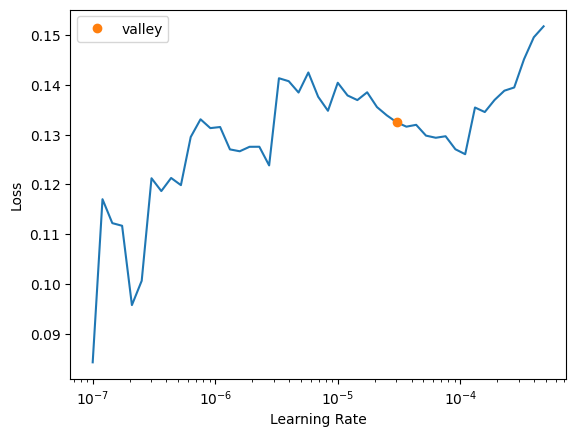

In [27]:
learn_leaky = learn_leaky.load('best_frozen_leaky')
learn_leaky.unfreeze()
lr_leaky = learn_ELU.lr_find()

In [29]:
learn_leaky.fit_one_cycle(
    40, lr_max=slice(lr_leaky.valley/10,lr_leaky.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_leaky_model')]
         )

epoch,train_loss,valid_loss,dice,time
0,0.174986,0.171028,0.465631,00:26
1,0.169684,0.177733,0.462692,00:27
2,0.171094,0.174747,0.282005,00:27
3,0.179435,0.187788,0.337868,00:26
4,0.183960,0.175637,0.478130,00:26
5,0.225296,0.237652,0.000000,00:27
6,0.200006,0.188369,0.000033,00:25
7,0.195300,0.174552,0.103044,00:27
8,0.171956,0.192885,0.396443,00:27
9,0.169140,0.174356,0.444123,00:26


Better model found at epoch 0 with dice value: 0.46563071752034507.
Better model found at epoch 4 with dice value: 0.478129718218083.
Better model found at epoch 11 with dice value: 0.49471193598550395.
Better model found at epoch 18 with dice value: 0.49837947564637103.
Better model found at epoch 19 with dice value: 0.5353225774072017.
Better model found at epoch 22 with dice value: 0.5365862571044687.
Better model found at epoch 24 with dice value: 0.5620518872653629.
No improvement since epoch 24: early stopping


In [30]:
learn_leaky = learn_leaky.load("best_leaky_model")
print("in-sample performance: {}".format(np.array(learn_leaky.validate(ds_idx=0)[1])))

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


in-sample performance: 0.8000210820249881


In [31]:
print("out-of-sample performance: {}".format(np.array(learn_leaky.validate(ds_idx=1)[1])))

out-of-sample performance: 0.5620518872653629


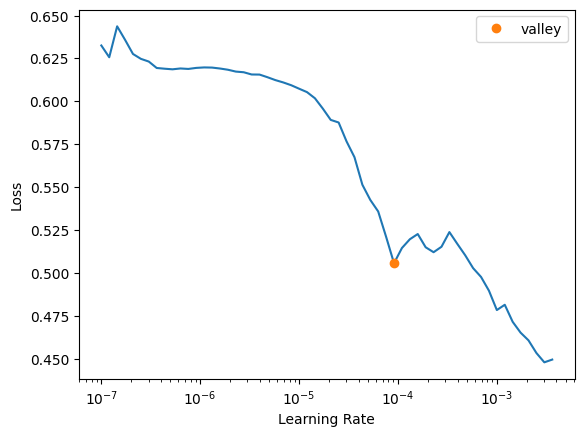

In [43]:
learn_GELU = unet_learner(dls16, resnet34, metrics=Dice, act_cls=torch.nn.GELU)
lr_GELU = learn_GELU.lr_find()

In [44]:
learn_GELU.fit_one_cycle(40, lr_max=lr_GELU.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_gelu')])

epoch,train_loss,valid_loss,dice,time


KeyboardInterrupt: 

In [ ]:
learn_GELU = learn_GELU.load('best_frozen_gelu')
learn_GELU.unfreeze()
lr_GELU = learn_GELU.lr_find()

In [ ]:
learn_GELU.fit_one_cycle(
    40, lr_max=slice(lr_GELU.valley/10,lr_GELU.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_gelu_model')]
         )

In [33]:
learn_GELU = learn_GELU.load("best_gelu_model")
print("in-sample performance: {}".format(np.array(learn_GELU.validate(ds_idx=0)[1])))

NameError: name 'learn_PReLU' is not defined

In [ ]:
print("out-of-sample performance: {}".format(np.array(learn_GELU.validate(ds_idx=1)[1])))